# Run LLMs locally

We will be using the `transformers` library to run LLMs locally with PyTorch as backend.  
This notebook will require a GPU with at least 12GB of VRAM.  
It is recommended to use Google Colab with at least a T4 GPU runtime.


This notebook will cover the following topics:
- Running LLMs locally
- VRAM limitations
- Quantization
- Using multimodal models
- Structured outputs with JSONformer

If you are using a Google Colab runtime, make sure to enable GPU acceleration in the runtime settings.

1. Click on the dropdown menu in the top right of "Connect" and select "Change runtime type"
<div>
<img src="./.images/colab_change_runtime_1.png" alt="Google Colab Enable GPU" width="500"/>
</div>

2. Select "T4 GPU" in the Hardware accelerator section and click "SAVE"
<div>
<img src="./.images/colab_change_runtime_2.png" alt="Google Colab Enable GPU" width="500"/>
</div>

3. Click on the "Connect" button in the top right of this notebook
<div>
<img src="./.images/colab_change_runtime_3.png" alt="Google Colab Connect" width="300"/>
</div>

In [ ]:
!pip install "transformers>=4.45.0" hf_transfer torch accelerate bitsandbytes pillow

# - transformers - high-level API for working with models
# - hf_transfer - allows for faster downloads from Hugging Face
# - torch - Backend library for transformers
# - accelerate - library for distributed inference / training - allows us to use device="auto"
# - bitsandbytes - allows for quantization of models on the fly
# - pillow - allows for image processing

# enable hf_transfer for faster downloads
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1" 

## Loading and using text models

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

### Loading the model and tokenizer

In [2]:
model_id = "Qwen/Qwen2.5-1.5B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype='auto', device_map="cuda:0")
tokenizer = AutoTokenizer.from_pretrained(model_id, torch_dtype='auto', device_map="cuda:0")


#### Define a message to send to the model

In [3]:
# Define a message to send to the model
messages = [
    {"role": "user", "content": "When was Alan Turing born?"}
]

# generate the chat template
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
print(text)

# tokenize the text in a batch of 1
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
model_inputs

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
When was Alan Turing born?<|im_end|>
<|im_start|>assistant



{'input_ids': tensor([[151644,   8948,    198,   2610,    525,   1207,  16948,     11,   3465,
            553,  54364,  14817,     13,   1446,    525,    264,  10950,  17847,
             13, 151645,    198, 151644,    872,    198,   4498,    572,  25282,
          94430,   9223,     30, 151645,    198, 151644,  77091,    198]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

#### Generate the output

In [4]:
# Set the PyTorch seed for reproducibility
torch.manual_seed(0)

# generate the output in inference mode (no gradient tracking)
with torch.inference_mode():
    batched_output_ids = model.generate(
        **model_inputs,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.2,
    )

# extract the generated tokens by skipping the input ids
generated_ids = [
    output_ids[len(input_ids):] 
    for input_ids, output_ids 
    in zip(model_inputs.input_ids, batched_output_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
response



Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


'Alan Turing was born on June 23, 1912.'

#### Unload Model from VRAM

In [5]:
def print_mem_stats():
    import torch
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e6:.2f} MB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1e6:.2f} MB")

def reclaim_memory():
    import gc
    import torch

    for _ in range(3):
        for gen in range(3):
            gc.collect(gen)
        torch.cuda.empty_cache()


In [6]:
del model
del tokenizer

reclaim_memory()

### Loading Gated Models from Hugging Face

Some models on Hugging Face are gated and require a token to be downloaded.  

Before downloading the model, You need to agree to the model's author terms of use.

<div>
<img src="./.images/hf_accept_model_tos.png" alt="Hugging Face Gated Model" width="500"/>
</div>

Now, create a new readonly token at [Hugging Face](https://huggingface.co/settings/tokens/new?tokenType=read) and store in a secure place.  
Then, set it in the `HF_TOKEN` environment variable.

In [ ]:
import os
print("Please fill in your Hugging Face token below")
os.environ["HF_TOKEN"] = input("Hugging Face token:")

#### Loading the gated model

We will be loading `meta-llama/Llama-3.1-8B-Instruct`, so make sure you nagivate to https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct before proceeding and accept the terms of use.

In [7]:
model_id = "meta-llama/Llama-3.1-8B-Instruct"

# using device_map="auto" will automatically shard the model on the GPU + CPU memory thanks to accelerate
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype='auto', device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_id, torch_dtype='auto', device_map="auto")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
messages = [
    {"role": "user", "content": "What is 2+2?"}
]

text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

with torch.inference_mode():
    batched_output_ids = model.generate(**model_inputs, max_new_tokens=512)

generated_ids = [
    output_ids[len(input_ids):] 
    for input_ids, output_ids 
    in zip(model_inputs.input_ids, batched_output_ids)
]
response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(response)


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


The answer is 4.


#### Streaming the generation

In [9]:
# streaming the output to stdout

from transformers import TextStreamer
streamer = TextStreamer(tokenizer)

with torch.inference_mode():
    model.generate(**model_inputs, max_new_tokens=512, streamer=streamer)

del streamer

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

What is 2+2?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

2 + 2 = 4.<|eot_id|>


In [10]:
from transformers import TextIteratorStreamer
from threading import Thread

streamer = TextIteratorStreamer(tokenizer)
thread = Thread(
    target=model.generate, 
    kwargs=model_inputs | {
        "streamer": streamer,
        "max_new_tokens": 512
    }
)

with torch.inference_mode():
    thread.start()

generated_text = ""
for new_text in streamer:
    generated_text += new_text
    print(new_text, end="", flush=True)

thread.join()

del streamer
del thread

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

What is 2+2?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

2 + 2 = 4.<|eot_id|>

In [11]:
del model
del tokenizer
reclaim_memory()

### Quantization

Quantization is a technique to reduce the model size and improve the inference speed.

Generating with the previous model might have been slow because it might have not fit in the GPU VRAM, having to be sharded across GPU, CPU, and possibly disk.

To easily calculate the memory footprint of the model, take the model data type and multiply it by the number of parameters.  
For example, `Llama-3.1-8B-Instruct` has a data type of `float16` (which is 2 bytes per parameter) and 8B parameters, so the memory footprint is 2 bytes/param * 8B params ~= 16GB.

Let's use `bitsandbytes` to quantize the model on the fly while loading it.

See the [Quantization documentation](https://huggingface.co/docs/transformers/main/en/quantization/overview) for more information.


In [12]:
from transformers import BitsAndBytesConfig

quantization_config_8bit = BitsAndBytesConfig(
    load_in_8bit=True,
)

quantization_config_4bit = BitsAndBytesConfig(
   load_in_4bit=True,
)

In [13]:
from time import perf_counter
from contextlib import contextmanager

@contextmanager
def catchtime(message: str = "Time"):
    t1 = t2 = perf_counter() 
    yield lambda: t2 - t1
    t2 = perf_counter() 
    print(f'{message}: {t2 - t1:.3f} seconds')

In [14]:
# setup a long story prompt for performance comparison

tokenizer = AutoTokenizer.from_pretrained(model_id, device_map="cuda:0")

messages = [
    {"role": "user", "content": "Tell me a long story about a cat"}
]

text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

model_inputs = tokenizer([text], return_tensors="pt").to('cuda:0')

del tokenizer

In [16]:
# Load the model with 8-bit quantization
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=quantization_config_8bit, device_map="cuda:0")

print_mem_stats()

with catchtime('Time with 8-bit quantization'):
    with torch.inference_mode():
        for _ in range(5):
            model.generate(**model_inputs, max_new_tokens=10)

del model
reclaim_memory()


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


GPU memory allocated: 9103.76 MB
GPU memory cached: 9162.46 MB


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Time with 8-bit quantization: 3.511 seconds


In [17]:
# Load the model with 4-bit quantization
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=quantization_config_4bit, device_map="cuda:0")

print_mem_stats()

with catchtime('Time with 4-bit quantization'):
    with torch.inference_mode():
        for _ in range(5):
            model.generate(**model_inputs, max_new_tokens=10)

del model
reclaim_memory()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


GPU memory allocated: 6089.88 MB
GPU memory cached: 6117.39 MB


/home/stefan/laborator/.venv/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:452: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Time with 4-bit quantization: 1.507 seconds


In [19]:
# Load the model without quantization
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype='auto', device_map="auto")

print_mem_stats()

with catchtime('Time without quantization'):
    with torch.inference_mode():
        for _ in range(5):
            model.generate(**model_inputs, max_new_tokens=10)

del model
reclaim_memory()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


GPU memory allocated: 16077.58 MB
GPU memory cached: 16219.37 MB


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Time without quantization: 0.994 seconds


Notice how the memory footprint is reduced when using quantization, but its not a perfect liniar scale, as the model has to retain some unquantized parameters for operations reasons.

`INT8` quantization:  
**Expected:** `1byte/param * 8B params = 8GB`  
**Actual:** `~9GB`  

`INT4` quantization:  
**Expected:** `0.5byte/param * 8B params = 4GB`  
**Actual:** `~6GB`  

Quantization is a trade-off between model size, model quality and inference speed.  

If the model fits in VRAM, it will be faster to run inference without quantization.  
Quantization will allow you to run inference with a smaller model size, but can be slower, depending on the hardware, model architecture, and model sharding on multiple devices.  

Quantizing to 8-bits usually does not come at a significant quality loss for the model.  
Quantizing to 4-bits can come at a larger quality loss, but can still be useful if you need to run the model on a low resource device.

## Loading and using multimodal models

We will be using `Qwen/Qwen2-VL-7B-Instruct` for this example.  
This model is a multimodal model that can understand images as well as text.  

The model is 8.3B parameters, requiring ~16.6GB of VRAM to load.  
Since we are constrained by VRAM, we will be using a pre-quantized version of the model from `Qwen/Qwen2-VL-7B-Instruct-GPTQ-Int8`


In [29]:
# install the optimum and auto-gptq libraries
# quantized qwen model depends on them
!pip install -q optimum auto-gptq

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [20]:
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor

model_id = "Qwen/Qwen2-VL-7B-Instruct-GPTQ-Int8"

model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype='auto',
    device_map="cuda:0",
)
processor = AutoProcessor.from_pretrained(model_id)

/home/stefan/laborator/.venv/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:411: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, qweight, scales, qzeros, g_idx, bits, maxq):
/home/stefan/laborator/.venv/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:419: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/home/stefan/laborator/.venv/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:461: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)
CUDA extension not installed.
CUDA extension not installed.
`Qwen2VLRotaryEmbedding` can now be fully parameteriz

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

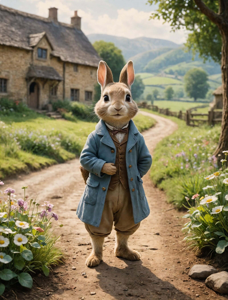

In [21]:
import requests
from PIL import Image
from IPython.display import Image as IPImage, display


image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/0052a70beed5bf71b92610a43a52df6d286cd5f3/diffusers/rabbit.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
display(image.resize((int(image.width / image.height * 300), 300)))

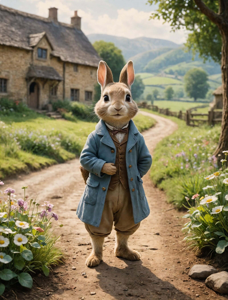

In the village green,  A rabbit in a coat,  Spring blooms around.


In [22]:
resized_image = image.resize((int(image.width / image.height * 300), 300))
display(resized_image)

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": "If I had to write a haiku for this one, it would be: "}
    ]}
]

input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

inputs = inputs = processor(
    text=[input_text], images=[resized_image], padding=True, return_tensors="pt"
).to(model.device)

output = model.generate(**inputs, max_new_tokens=128)
print(processor.decode(output[0][len(inputs['input_ids'][0]):], skip_special_tokens=True))

## Structured outputs

When generating the next token, models have a vector of probabilities representing the likelihood of each token in the vocabulary to be the next token.  
We will use a library that constrains the generation process to produce valid JSON output.

We will be using the [`outlines`](https://github.com/dottxt-ai/outlines/) library to constrain the generation process.

In [35]:
# there's currently a bug in the outlines library 
# during the installation process it assumes that rust is already installed
# in colab and other linux environments this is not the case
# so we need to install rust first
import os
!curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh -s -- -y
!source $HOME/.cargo/env
os.environ['PATH'] += f':{os.environ["HOME"]}/.cargo/bin'
!echo $PATH
!pip install -q "outlines==0.1.0"

info: downloading installer


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


info: profile set to 'default'
info: default host triple is x86_64-unknown-linux-gnu
info: syncing channel updates for 'stable-x86_64-unknown-linux-gnu'
info: default toolchain set to 'stable-x86_64-unknown-linux-gnu'

  stable-x86_64-unknown-linux-gnu unchanged - rustc 1.81.0 (eeb90cda1 2024-09-04)


Rust is installed now. Great!

To get started you may need to restart your current shell.
This would reload your PATH environment variable to include
Cargo's bin directory ($HOME/.cargo/bin).

To configure your current shell, you need to source
the corresponding env file under $HOME/.cargo.

This is usually done by running one of the following (note the leading DOT):
. "$HOME/.cargo/env"            # For sh/bash/zsh/ash/dash/pdksh
source "$HOME/.cargo/env.fish"  # For fish


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/stefan/laborator/.venv/bin:/home/stefan/.cursor-server/cli/servers/Stable-c499aee5f16e67815c7dc795ff338dc8ab3e07f0/server/bin/remote-cli:/home/stefan/.local/bin:/home//home/stefan/.local/bin:/usr/local/pyenv/shims:/usr/local/pyenv/bin:/usr/local/nvm/versions/node/v22.9.0/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/home/stefan/.cargo/bin:/home/stefan/.cargo/bin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


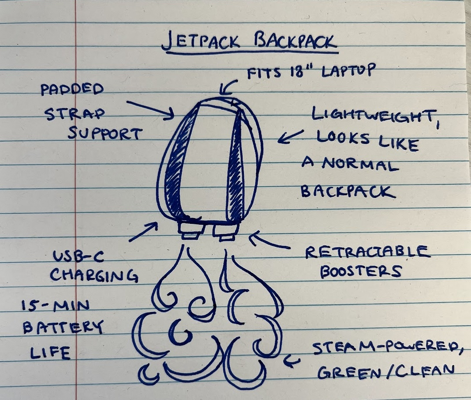

In [23]:
from PIL import Image
import requests
from IPython.display import display

image_url = "https://storage.googleapis.com/generativeai-downloads/images/jetpack.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
display(image.resize((int(image.width / image.height * 400), 400)))

In [24]:
from outlines.processors.structured import JSONLogitsProcessor
from outlines.models.transformers import TransformerTokenizer
from pydantic import BaseModel, Field
import json

# create a Pydantic schema for the output
class BackpackFeatures(BaseModel):
    feature: str = Field(description="A feature of the backpack")

class ImageDetails(BaseModel):
    title: str = Field(description="The title of the image")
    features: list[BackpackFeatures] = Field(description="A list of features of the backpack")

# convert the schema to a JSON schema
schema = ImageDetails.model_json_schema()
schema_text = json.dumps(schema)

# create a JSON logits processor
json_logits_processor = JSONLogitsProcessor(schema, TransformerTokenizer(processor.tokenizer))

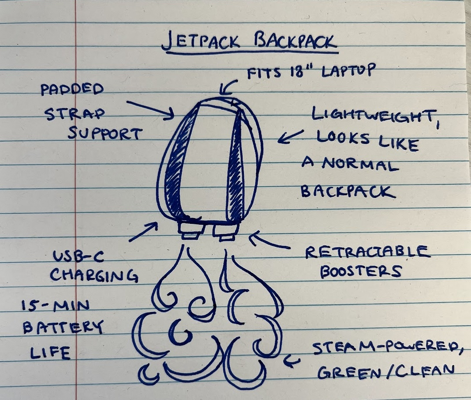

{'features': [{'feature': 'Padded Strap Support'},
              {'feature': 'Fits 18" Laptop'},
              {'feature': 'Lightweight, Looks Like a Normal Backpack'},
              {'feature': 'USB-C Charging'},
              {'feature': 'Retractable Boosters'},
              {'feature': '15-Min Battery Life'},
              {'feature': 'Steam-Powered, Green/Clean'}],
 'title': 'Jetpack Backpack'}


In [25]:
resized_image = image.resize((int(image.width / image.height * 400), 400))
display(resized_image)

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": f"""
Describe the image in detail. 

Respond in valid JSON, formatted following the schema: {schema_text}
""".strip()}
    ]}
]



input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

inputs = inputs = processor(
    text=[input_text], images=[resized_image], padding=True, return_tensors="pt"
).to(model.device)

output = model.generate(**inputs, max_new_tokens=512, logits_processor=[json_logits_processor])
# output = model.generate(**inputs, max_new_tokens=512)

json_text = processor.decode(output[0][len(inputs['input_ids'][0]):], skip_special_tokens=True)
json_data = json.loads(json_text)

from pprint import pprint
pprint(json_data)